In [1]:
import numpy as np
from time import time
from scipy.linalg import cholesky
import matplotlib.pyplot as plt

## Parameter Initiatlisation

In [2]:
# Initialise parameters - as of 1-Sep-23
NKY = 32710.62
SPX = 4515.77
HSI = 18382.06
T = 2 # year-to-maturity in years
r = 0.04876 # 2yr US Treasury Bond Yield

# initial variances - made up
vol_NKY = 0.4
vol_SPX = 0.3
vol_HSI = 0.45

# Correlation matrix - as of 1-Sep-22
rho = np.array([[1,0.187,0.421],
               [0.187,1,0.11],
               [0.421,0.11,1]])

# Autocallable parameters
note_D = 10000   # note denomination
max_CR = 0.1     # minimum coupon rate
min_CR = 0.05    # maximum coupon rate
KO = 1.1         # knock-out price
KI = 0.5         # knock-in price
obs_days = 126   # observation every X days
target = 0.98    # target note price (%)

## Implementation

In [3]:
# Monte Carlo specific parameters
N = T * 252   # discrete time steps
M = 1000     # number of simulations

# Start Timer
start_time = time()

# Precompute constants
dt = T/N
nu1dt = (r - 0.5*vol_NKY**2)*dt
nu2dt = (r - 0.5*vol_SPX**2)*dt
nu3dt = (r - 0.5*vol_HSI**2)*dt
vol1sdt = vol_NKY*np.sqrt(dt)
vol2sdt = vol_SPX*np.sqrt(dt)
vol3sdt = vol_HSI*np.sqrt(dt)

# Perform (lower) cholesky decomposition
lower_chol = cholesky(rho, lower=True)

# Generate correlated Wiener variables
W = np.random.normal(0, 1, size=(N,M,3))
Z = W @ lower_chol.T

# Monte Carlo Simulation
St1 = np.full(shape=(N+1, M), fill_value=NKY)
St2 = np.full(shape=(N+1, M), fill_value=SPX)
St3 = np.full(shape=(N+1, M), fill_value=HSI)

for j in range(1,N+1):
    St1[j] = St1[j-1] * np.exp(nu1dt + vol1sdt * Z[j-1,:,0])
    St2[j] = St2[j-1] * np.exp(nu2dt + vol2sdt * Z[j-1,:,1])
    St3[j] = St3[j-1] * np.exp(nu3dt + vol3sdt * Z[j-1,:,2])

laggard = np.minimum(St1/NKY, St2/SPX, St3/HSI)

########################################## End of Monte Carlo Simulation ####################################################

# Calculate redemption
redemption = np.zeros(M)

# Compute knock-out date (if no knock-out event, knock-out date = N+1)
KO_date = np.full(shape=M, fill_value=N+1)
for j in range(N,obs_days-1,-obs_days):
    KO_date[laggard[j]>=KO] = j

# Compute knock-out redemption
KO_mask = (KO_date != (N+1))
redemption[KO_mask] += note_D * np.exp(-r * KO_date[KO_mask]/252)

# Compute knock-in redemption
KI_mask = np.any(laggard <= KI, axis=0)
redemption[~KO_mask] += note_D * np.minimum(1, laggard[-1][~KO_mask] * KI_mask[~KO_mask]) * np.exp(-r*T) # knock-in event
redemption[~KO_mask] += note_D * ~KI_mask[~KO_mask] * np.exp(-r*T) # no knock-in event

# Get upper bound for Bisection method
CS = 0
while True: # Calculate coupon payments
    coupon = np.zeros(M)
    for j in range(obs_days, N+1, obs_days):
        coupon[KO_date >= j] += (laggard[j] >= CS)[KO_date >= j] * note_D * max_CR * np.exp(-r*j/252) # Max coupon rate
        coupon[KO_date >= j] += (laggard[j] < CS)[KO_date >= j] * note_D * min_CR * np.exp(-r*j/252) # Min coupon rate
    note0 = redemption + coupon
    E = np.sum(note0)/M
    if E/note_D < target:
        break
    CS += 1

# Bisection method
a = 0 # Upper bound
b = CS # Lower bound
while True: # Find the optimal CS
    CS = (a+b)/2
    coupon = np.zeros(M)
    for j in range(obs_days, N+1, obs_days):
        coupon[KO_date >= j] += (laggard[j] >= CS)[KO_date >= j] * note_D * max_CR * np.exp(-r*j/252)
        coupon[KO_date >= j] += (laggard[j] < CS)[KO_date >= j] * note_D * min_CR * np.exp(-r*j/252)
    note0 = redemption + coupon
    E = np.sum(note0)/M
    if abs(E/note_D - target) < 0.0001:
        break
    if (E/note_D > target):
        a = CS
    else:
        b = CS

# Print out results
print("Coupon strike is {0}%".format(np.round(CS,4)*100))
print("Calculation time: {0} sec".format(round(time() - start_time,2)))

Coupon strike is 103.71%
Calculation time: 0.15 sec


## Visualisation

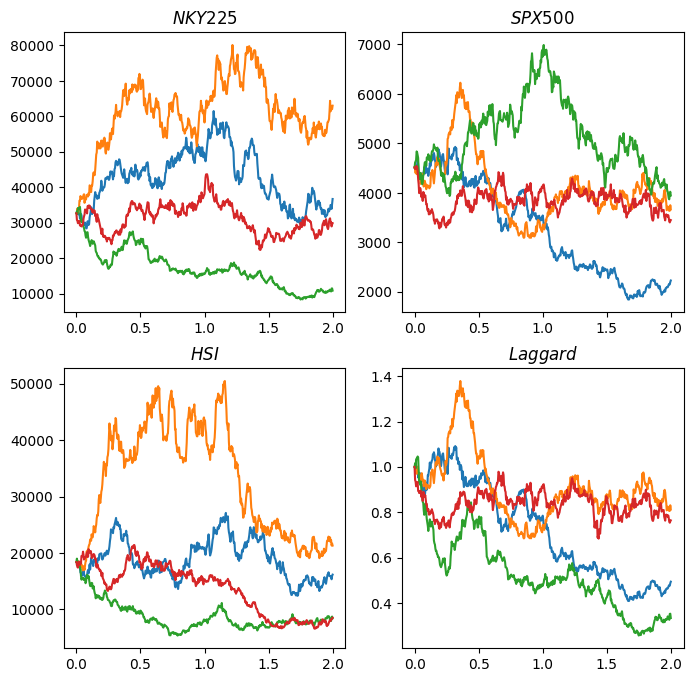

In [7]:
t = np.linspace(0, T, N+1)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
ax[0,0].plot(t, St1[:,:4]) # Only 4 paths are shown
ax[0,0].set_title('$NKY225$')
ax[0,1].plot(t, St2[:,:4]) # Only 4 paths are shown
ax[0,1].set_title('$SPX500$')
ax[1,0].plot(t, St3[:,:4]) # Only 4 paths are shown
ax[1,0].set_title('$HSI$')
ax[1,1].plot(t, laggard[:,:4]) # Only 4 paths are shown
ax[1,1].set_title('$Laggard$')
plt.show()

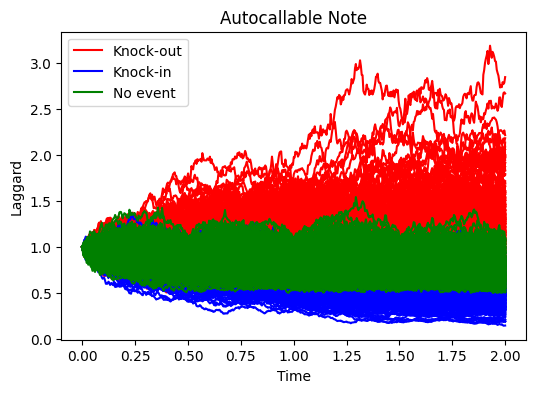

In [8]:
t = np.linspace(0, T, N+1)
plt.figure(figsize=(6,4))

plt.plot(t,np.ones(N+1), color='r',label='Knock-out')
plt.plot(t,np.ones(N+1), color='b',label='Knock-in')
plt.plot(t,np.ones(N+1), color='g',label='No event')

plt.plot(t,laggard[:,KO_mask], color='r') # knock-out paths
plt.plot(t,laggard[:,~KO_mask][:,KI_mask[~KO_mask]], color='b') # knock-in paths
plt.plot(t,laggard[:,~KO_mask][:,~KI_mask[~KO_mask]], color='g') # no event paths

plt.title('Autocallable Note')
plt.xlabel('Time')
plt.ylabel('Laggard')
plt.legend()

plt.show()

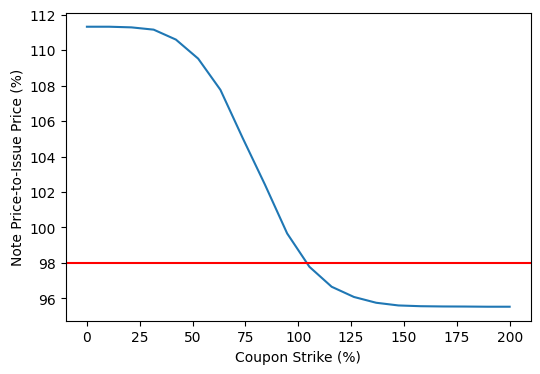

In [9]:
x = np.linspace(0, 2, 20)
y = np.zeros(20)
for index, CS in enumerate(x):
    coupon = np.zeros(M)
    for j in range(obs_days, N+1, obs_days):
        coupon[KO_date >= j] += (laggard[j] >= CS)[KO_date >= j] * note_D * max_CR * np.exp(-r*j/252)
        coupon[KO_date >= j] += (laggard[j] < CS)[KO_date >= j] * note_D * min_CR * np.exp(-r*j/252)
    note0 = redemption + coupon
    E = np.sum(note0)/M
    y[index] = E/note_D

plt.figure(figsize=(6,4))
plt.plot(x*100,y*100)
plt.axhline(y=98,color='r',linestyle='-')
plt.xlabel('Coupon Strike (%)')
plt.ylabel('Note Price-to-Issue Price (%)')
plt.show()